In [57]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob 
from sunpy.time import parse_time 
from sunpy import timeseries as ts 
import datetime
from matplotlib import dates
from scipy.signal import savgol_filter
import scipy.stats
import plotly.express as px
plt.ion()

import seaborn as sns
sns.set_context("paper")

In [11]:
vlf_flares = pd.read_csv("final_paper_vlf_flares.csv")
vlf_flares["event_starttime"] = pd.to_datetime(vlf_flares["event_starttime"])

In [12]:
def calc_amp(x):
    return 20*np.log10(x + 5) - 61 + 107

def sid_to_series(file, amp=False):

    sid = pd.read_csv(file, comment="#", names=["times", "data"])
    tt = parse_time(sid["times"]).datetime
    if amp:
        ser = pd.Series(calc_amp(sid["data"].values), index=tt)
    else:
        ser = pd.Series(sid["data"].values, index=tt)		
    ser.sort_index(inplace=True)
    return ser

# File patterns
sid_file_dir = "/Users/laurahayes/ionospheric_work/vlf_data_all_birr/sid_alll/*%Y%m%d*NAA*"
goes_file_dir = "/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/*%Y%m%d*.fits"

In [23]:
def get_pandas_df_of_results():
    errors = []
    results = []
    save=True
    for i in range(0, len(vlf_flares)):
        try:
            new_ts = pd.to_datetime(vlf_flares["event_starttime"].iloc[i])-datetime.timedelta(minutes=5)
            new_te = pd.to_datetime(vlf_flares["event_endtime"].iloc[i])+datetime.timedelta(minutes=5)

            # SID data
            sid_file = glob.glob(vlf_flares.iloc[i]["event_starttime"].strftime(sid_file_dir))[0]
            sid_data = sid_to_series(sid_file).truncate(new_ts, new_te)
            sid_data_db = sid_to_series(sid_file, amp=True).truncate(new_ts, new_te)

            # smoothing window defined in terms of cadence
            window_sec =  (sid_data.index[1] - sid_data.index[0]).total_seconds()
            window = int((2*60)/window_sec)
            if window%2 == 0:
                window = window+1

            sid_resample = pd.Series(savgol_filter(sid_data, int(window), 3), index=sid_data.index)
            sid_resample_flare = sid_resample.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])
            sid_resample_db = pd.Series(savgol_filter(sid_data_db, int(window), 3), index=sid_data_db.index)
            sid_resample_flare_db = sid_resample_db.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])                
            # GOES data
            goes_file = glob.glob(pd.to_datetime(vlf_flares["event_starttime"].iloc[i]).strftime(goes_file_dir))[0]
            goes = ts.TimeSeries(goes_file).truncate(new_ts, new_te)
            gl = goes.to_dataframe()["xrsb"]
            gs = goes.to_dataframe()["xrsa"]
            gl_flare = gl.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])
            gs_flare = gs.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])


            peak_vlf = np.max(sid_resample_flare)
            peak_vlf2 = np.abs(np.max(sid_resample_flare) - sid_resample_flare[0])

            peak_vlf_db = np.max(sid_resample_flare_db)
            peak_vlf2_db = np.abs(np.max(sid_resample_flare_db) - sid_resample_flare_db[0])

            dt_value_gl = (sid_resample_flare.index[np.argmax(sid_resample_flare)] - gl_flare.index[np.argmax(gl_flare)]).total_seconds()
            dt_value_gs = (sid_resample_flare.index[np.argmax(sid_resample_flare)] - gs_flare.index[np.argmax(gs_flare)]).total_seconds()

            event = {}
            event["start_time_goes"] = vlf_flares.iloc[i]["event_starttime"]
            event["peak_flare_gl"] = np.max(gl_flare)
            event["peak_flare_gs"] = np.max(gs_flare)
            event["max_vlf"] = peak_vlf
            event["abs_vlf"] = peak_vlf2
            event["max_vlf_db"] = peak_vlf_db
            event["abs_vlf_db"] = peak_vlf2_db
            event["dt_value_gl"] = dt_value_gl
            event["dt_value_gs"] = dt_value_gs


            results.append(event)
        except:
            print("error", i)
    results = pd.DataFrame(results)

    merged_results = pd.merge(results, vlf_flares, left_on="start_time_goes", right_on="event_starttime")
    merged_results.to_csv("vlf_stats_results.csv", index_label=False)

In [79]:
vlf_stats = pd.read_csv("vlf_stats_results.csv")
vlf_stats["start_time_goes"] = pd.to_datetime(vlf_stats["start_time_goes"])

In [80]:
vlf_stats[["peak_flare_gl", "goes_class_val"]]

,peak_flare_gl,goes_class_val
0,0.000014,0.000013
1,0.000003,0.000003
2,0.000006,0.000005
3,0.000003,0.000003
4,0.000003,0.000003
...,...,...
337,0.000002,0.000002
338,0.000003,0.000003
339,0.000001,0.000001
340,0.000008,0.000008


# Lets make the paper plots 

### Peak flux/amplitude relationships

Text(0.85, 0.06, 'C.C. 0.70')

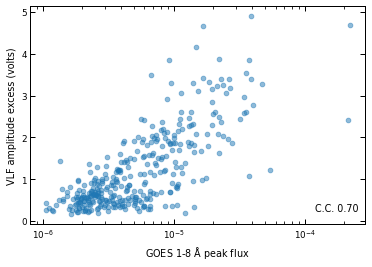

In [81]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf"], alpha=0.5)
ax.set_xscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 1-8 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (volts)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)

Text(0.85, 0.06, 'C.C. 0.71')

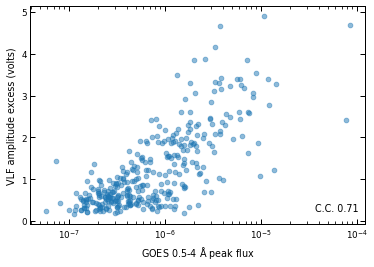

In [82]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf"], alpha=0.5)
ax.set_xscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 0.5-4 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (volts)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)

Text(0.85, 0.06, 'C.C. 0.76')

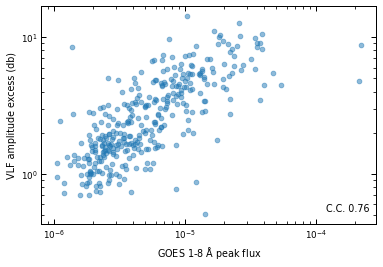

In [83]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 1-8 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (db)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf_db"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)

Text(0.85, 0.06, 'C.C. 0.77')

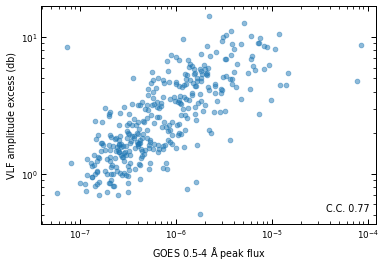

In [84]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 0.5-4 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (db)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf_db"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)

### Seasonal and hourly variations

In [86]:
vlf_stats["hour"] = pd.to_datetime(vlf_stats.start_time_goes.dt.strftime("2012-01-01 %H:00"))
vlf_stats["month"] = pd.to_datetime(vlf_stats.start_time_goes.dt.strftime("2012-%b-01 00:00"))

### Hourly

Text(0.5, 0, 'Hour of the Day')

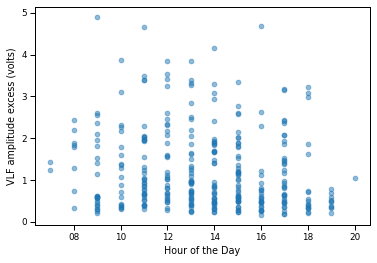

In [102]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["hour"], vlf_stats["abs_vlf"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%H"))
ax.set_ylabel("VLF amplitude excess (volts)")
ax.set_xlabel("Hour of the Day")



Text(0.5, 0, 'Hour of the Day')

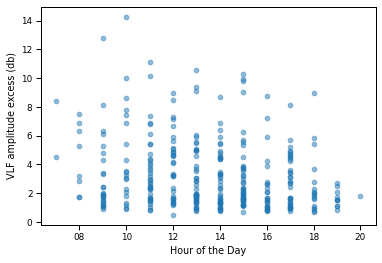

In [103]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["hour"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%H"))
ax.set_ylabel("VLF amplitude excess (db)")
ax.set_xlabel("Hour of the Day")

### Seasonal

Text(0.5, 0, 'Month of the Year')

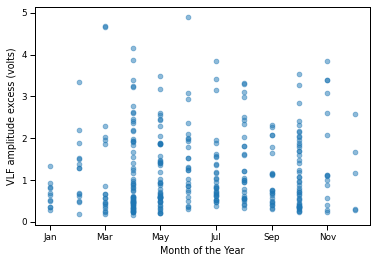

In [106]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["abs_vlf"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude excess (volts)")
ax.set_xlabel("Month of the Year")


Text(0.5, 0, 'Month of the Year')

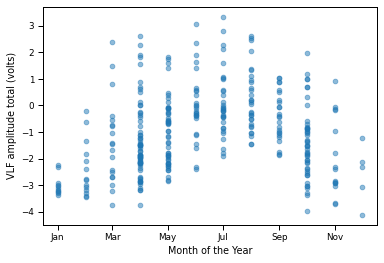

In [108]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["max_vlf"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude total (volts)")
ax.set_xlabel("Month of the Year")



Text(0.5, 0, 'Month of the Year')

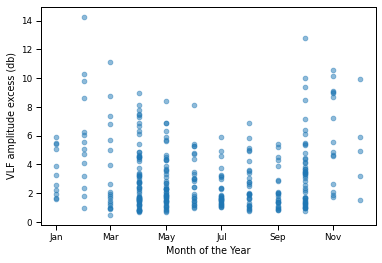

In [111]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude excess (db)")
ax.set_xlabel("Month of the Year")





Text(0.5, 0, 'Month of the Year')

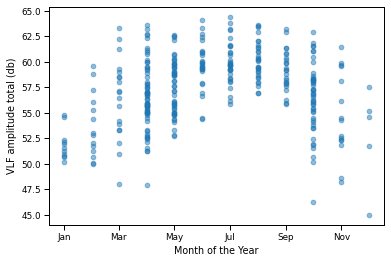

In [110]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["max_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude total (db)")
ax.set_xlabel("Month of the Year")


